<a href="https://colab.research.google.com/github/steed360/Data-Analysis/blob/main/a_Regression_Errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Create charts to illustrate and better understand which distributions of Y will produce linear regression models that satisfy the "regression assumptions", including:

- Error terms will be normally distributed
- Same std deviation for the error term regardless of position along X


Introduction:

- Text books warn against using regression (directly) to explain a variable that has a long tail.
- Examples of such data are income distributions and travel time distributions. - This is also mentioned in relation to survival analysis.

For a beginner this raises two quesitons:

- What kind of data is most suitable for attempting a linear regression?
- What is it about skewed data that makes it unsuitable for linear regression?

Both of these questions can be addressed by simple thought experiments.

In this notebook we try to visualize the issue using simple fitted regression models (where we already have the co-efficients). We can sample from the error term to create a dataset.  This dataset would have come from a distribution which we call the Originating Distribution. To gain elementary intuition, we're interested in the shape of this distribution.


In Part 2 we sample from an model in which there is non constant variance. That is to say there is more less precision in the estimates of Y towards bigger values of X. What kind of Originating Distribution do we get in this case?

Method:

Part One:

- Firstly start with a fitted model (estimating height for a given weight)
- The model was generated in the Statistical Rethiking dataset using the Howell dataset of bushmen of the Kalahari. (People who are 5ft tall appear very light by our standards)
- Plot the regression line and estimated mean height for a few weight values.
- Then visualize the normal distribution around each of these estimated mean heights. Following the regression assumptions each Normal distribution should have the same standard deviation.
- The prevoius step is done by sampling from the following:
  yi~N( mean = + 154cm + weight * slope , std= 4)
- In this simple example, regression could be seen as producing conditional Normal Distributions (all with the same standard deviation)
- Now sample from each of the Conditional Distributions and the visualize the "Originating Distribution".
- Is it Normally Distributed? No.

Part Two:

- Repeat the data sampling in Part One (again sample from the regression equation)
- This time increase the variance for the last two weight points.
- Again, visualize the regression line and the Conditional Normal Distributions around each of the estimated mean heights.
- Once again visualize the shape of the "Originating distribution". It is somewhat skewed like income data.
- Let's imagine that we were starting with data and wanted to do a regression. Where would we go wrong?
- Estimate the regression line using data sampled from the "Originating Distribution".  Also find the standard deviation of the residuals.
- Overlay the distribution of errors onto the actual distribution.
- A large residual standard error translates into less certainty of the estimated co-efficients.
- Therefore having skewed data has caused us to be less under-confident for the two smaller weight points and to be over-confident for the two larger weight points.



In [122]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import pandas.api.types as pdtypes # for (sorted) categories.

import matplotlib.pyplot as plt

import scipy.stats as stats

import arviz as az

import plotnine
#from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine import *
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_line
from plotnine import ggplot  # https://plotnine.readthedocs.io/en/stable/
from plotnine import geom_violin, geom_density

import matplotlib
from matplotlib import gridspec

%matplotlib inline

from mizani import formatters # for better axis labelling
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.patches import Rectangle


In [123]:
# define colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
BLUE5, BLUE6 = '#92CDDD', '#2E869D'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1, ORANGE2, ORANGE3 = '#F79747', '#FAC090', '#F36721'

In [124]:
# configure plot font family to Arial
#plt.rcParams['font.family'] = 'Arial'
# configure mathtext bold and italic font family to Arial
#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
#matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

In [125]:
# Specify the chart layout (PowerBI all is forgiven.... :)

def SWD_theme ():

    font = "Arial" # doesn't work on Colab
    #t=theme_minimal(base_size = 10, base_family = font )
    t=theme_minimal(base_size = 10 )

    t2 = theme(
      #panel_grid_major = element_blank(),
      panel_grid_major = element_line(size = 0.5, color = GRAY9),
      panel_grid_minor = element_line(size = 0.5, color = GRAY9),

      #panel_grid_minor = element_blank(),
      axis_line = element_line(size = .1, color = GRAY9),
      axis_text = element_text(color = GRAY3, size = 12),
      #axis.ticks.x = element_line(size = 0.5, color = GRAY9),
      #axis.ticks.y = element_line(size = 0.5, color = GRAY9),
      axis_title = element_text(color = GRAY3),
      #axis_title_y = element_text(hjust = 1, margin = margin(0, 6, 0, 15, "pt")),
      #axis_title_x = element_text(hjust = 0, margin = margin(6, 0, 15, 0, "pt")),
      #plot_subtitle = element_text(color = GRAY4, size= 8),
      plot_title = element_text(color = GRAY4, size= 12 ),
      # I don't think this line is implemented in plotnine
      #plot_title_position = "plot", # This aligns the plot title to the very left edge
      #plot_caption = element_text(hjust = 0, color = GRAY6),
      #plot_caption_position = "plot",
      #plot_margin = margin(.5,.5,.5,.5,"cm"),
      #plot_margin = (0.4 ),
      strip_text = element_text(color = GRAY7))

    return t+ t2

# Part One

#### Sample from the normal distribution for each of the four points, specifically sample from N ( mu = 30, s= 5), N (mu=40, s=5) etc

In [126]:
# Specify some x values.
lst_x =  [i for i in range ( 20,60, 10)]
np_x = np.array ( lst_x)

# Produce some Yi values using
# a model of height = function (weight) from Statistical Rethinking
# Place in a dict for later retrieval.

b_weight_kg = 0.9
c_avg_height_cm = 113.79
sd = 5.0  # standard deviation of errors.

dictYi = {}

for xi in lst_x:
  dictYi[xi] = c_avg_height_cm  + b_weight_kg * xi

dictYi


{20: 131.79000000000002,
 30: 140.79000000000002,
 40: 149.79000000000002,
 50: 158.79000000000002}

In [127]:
#####################################
# A simple data frame is needed to do a line chart
###################################

lst_Yi = [dictYi[xi] for xi in dictYi.keys() ]

data_x_y = pd.DataFrame ( {'x':lst_x,'y':lst_Yi})

# Currently doing this as a categorical variable because the violin plot requires a categorical X Axis
data_x_y['variable'] = data_x_y['x'].astype(pdtypes.CategoricalDtype(categories=[20,30,40,50]))
data_x_y['group'] = 1

data_x_y

,x,y,variable,group
0,20,131.79,20,1
1,30,140.79,30,1
2,40,149.79,40,1
3,50,158.79,50,1


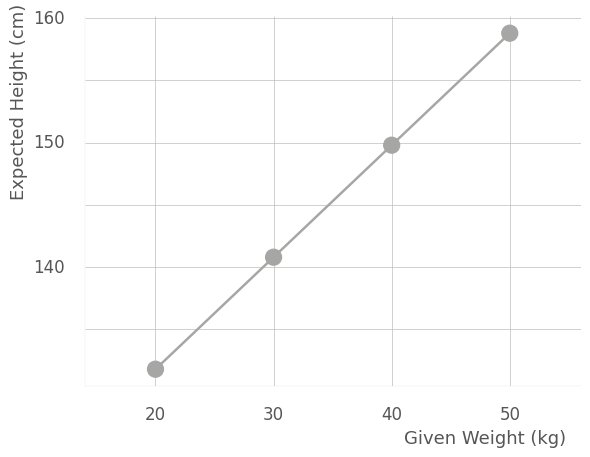

<ggplot: (8461936598479)>

In [128]:
from plotnine import geom_violin
from plotnine import ggplot, aes, theme

t = theme(
          # Overrides
          axis_title_y = element_text(angle = 90, va = 'bottom', ha = 'left', size = 13, color = GRAY3, y = 0.5),
          axis_title_x = element_text(  size = 13, color = GRAY3, x=0.75),
          #panel_grid_major_y=element_blank(),
          legend_position="none"
)

lsize = 0.1
shift = -0.06
shift_point = 0.07

# For shifting the violin plot
def alt_sign(x):
    "Alternate +1/-1 if x is even/odd"
    #return (-1) ** x
    return

fig = \
(ggplot()
  + geom_line (data_x_y,aes( x='variable', y='y', group = 'group', size=2),color=GRAY8 )
  + geom_point (data_x_y, aes( x='variable', y='y',size=10), color=GRAY8 )
  + labs(y = "Expected Height (cm)    "  , x = "Given Weight (kg)")
  +  SWD_theme() + t

)

fig

Sample from the 4 normal distributions (specifing a constant st dev of 5 cm)

In [129]:
dictYi

{20: 131.79000000000002,
 30: 140.79000000000002,
 40: 149.79000000000002,
 50: 158.79000000000002}

In [130]:
# Specify some x values.
lst_x =  [i for i in range ( 20,60, 10)]
np_x = np.array ( lst_x)


# Produce some Yi values using
# a model of height = function (weight) from Statistical Rethinking
# Place in a dict for later retrieval.


b_weight_kg = 0.9
c_avg_height_cm = 154
sd = 5.0  # standard deviation of errors.

#N = 100              # Number of data points to generate.
N = 100000              # Number of data points to generate.

# Create a dataframe (with x as columns and yi~N() samples as rows)

df = pd.DataFrame()

for xi in lst_x:
    yi = dictYi[xi]
    df[xi] = stats.norm.rvs(yi , 5, N)

###################################

# A long version of this dataframe is needed for plotting as violin plots
import pandas.api.types as pdtypes # for (sorted) categories.
df_long = pd.melt(df,value_vars=[20,30,40,50]  )
df_long['x'] = df_long['variable']
df_long['variable'] = df_long['variable'].astype(pdtypes.CategoricalDtype(categories=[10,20,30,40,50,60]))




Do violin plot

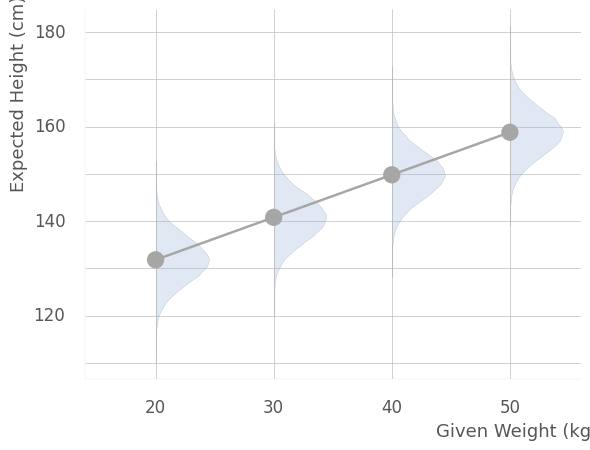

<ggplot: (8461936761382)>

In [131]:
from plotnine import geom_violin
from plotnine import ggplot, aes

t = theme(
          # Overrides
          axis_title_y = element_text(angle = 90, va = 'bottom', ha = 'left', size = 13, color = GRAY3, y = 0.5),
          axis_title_x = element_text(  size = 13, color = GRAY3, x=0.7),
          #panel_grid_major_y=element_blank(),
          legend_position="none"
)

lsize = 0.1
shift = -0.06
shift_point = 0.07

# For shifting the violin plot
def alt_sign(x):
    "Alternate +1/-1 if x is even/odd"
    #return (-1) ** x
    return

m1 = aes(x=stage('variable', after_scale='x+shift*x'))                 # shift outward
m2 = aes(x=stage('variable', after_scale='x+shift_point*x'))           # shift outward
m3 = aes( stage('variable', after_scale='x+shift_point*x' ),y='vals' )

fig = \
(ggplot(df_long, aes('variable', 'value',group = 'variable'))
  + geom_violin( alpha=0.3, color=GRAY8, fill=BLUE3, style="right", size=lsize)
  #+ geom_point(m2, alpha=0.005, color=GRAY8,size=0.2)
  + geom_line (data_x_y,aes( x='variable', y='y', group = 'group', size=2),color=GRAY8 )
  + geom_point (data_x_y, aes( x='variable', y='y',size=10), color=GRAY8 )
  + labs(y = "Expected Height (cm)     "  , x = "Given Weight (kg)")
  +SWD_theme() + t
)


fig

Plot the densities
- Each of the conditional normal distributions
- Originating Distribution: Building up a distribution by sampling an equal number of value from each of the 4 conditional normal distributions
- Lastly, find the meand and std. dev. of the above distribution. Sample from a Normal Distribution using these parameters.

The last step is intended to give a visual comparison of the originating distribution and a normal one with the same mean and variance.

In [132]:
# Find the mean and standard deviation in order to give a comparison.
std1 = np.std (df_long['value'] )
mu1  = np.mean (df_long['value'] )
# Repeat the distribution for the data sampled from across the 4 conditional normal dists
# And add the properly shaped normal one just defined

df_Normal = pd.DataFrame ( { 'value': stats.norm.rvs( mu1 ,std1, N) })

(0.0, 1.0, 0.0, 1.0)

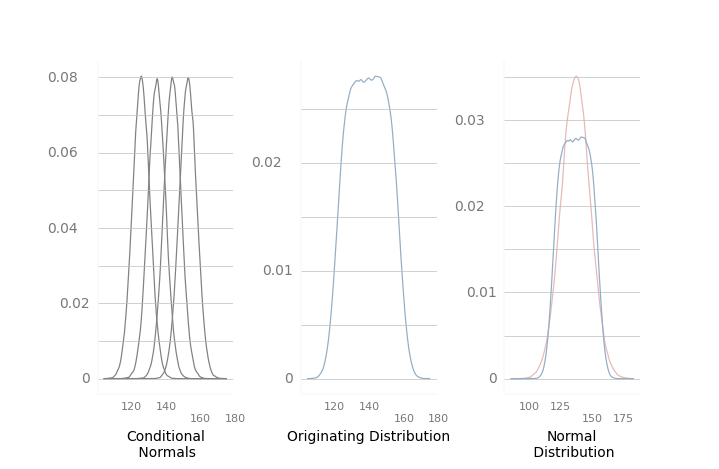

In [133]:
t = theme(
          # Overrides
          axis_title_y = element_text(angle = 90, va = 'bottom', ha = 'left', size = 13, color = GRAY3, y = 0.8),
          axis_title_x = element_text(  size = 13, color = GRAY3, x=0.8),
          #panel_grid_major_y=element_blank(),
          panel_grid_major_x=element_blank(),
          panel_grid_minor_x=element_blank(),
          axis_text_y = element_text( color=GRAY5, size=10)  ,
          axis_text_x = element_text( color=GRAY5, size=8, y = 0, va="top", ha="left")  ,
          #va = 'bottom', ha = 'left', size = 13, color = GRAY3, y = 0.5
          legend_position="none"
)

# Conditional distributions
p1 = \
  (ggplot(df_long, aes(x='value', group='variable') )
  + geom_density (alpha=0.1, color=GRAY6)
  + labs(y = "Density     "  , x = "Given Weight (kg)")
  + scale_x_continuous(limit = [150, 220])
   +SWD_theme() + t
)

# Originating distribution
p2 = \
  (ggplot(df_long, aes(x='value'))
  + geom_density (alpha=0.1,  color=BLUE4)
  + labs(y = "Density     "  , x = "Given Weight (kg)")
  +SWD_theme() + t
)

# Normal Distribution
p3 = \
  (ggplot(df_Normal, aes(x='value'))
  + geom_density (alpha=0.1,  color=RED2)
  + geom_density (df_long, aes(x='value'), color=BLUE4 )
  + labs(y = "Density     "  , x = "Given Weight (kg)")
  +SWD_theme() + t
)

# Empty plotnine figure to place the subplots on. Needs junk data (for backend "copy" reasons).
fig = (ggplot()+geom_blank(data=df) +theme_void()).draw(show=False, return_ggplot=False)

# Create gridspec for adding subpanels to the blank figure
gs = gridspec.GridSpec(1, 3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

gs.update(wspace=0.5, hspace=0.05) # set the spacing between axes.

# Add subplots to the figure
_=p1._draw_using_figure(fig, [ax1])
_=p2._draw_using_figure(fig, [ax2] )
_=p3._draw_using_figure(fig, [ax3] )

fig.dpi = 100
width_in = 7
fig.set_size_inches(width_in , width_in/1.62)

# X axis labels.
fig.axes[1].set_xlabel ('Conditional\n Normals')
fig.axes[2].set_xlabel ('Originating Distribution')
fig.axes[3].set_xlabel ('Normal\n Distribution')

ax0 = fig.add_axes( (0,0,1,1))
ax0.axis('Off') # don't draw anything.

The Originating distribution is wider than a Normal distribution of the same mean and variance

Use the data sampled from the Originating Distribution to plot the regression line alongside the residual standard error

In [134]:
import scipy
slope, intercept, r, p, se = scipy.stats.linregress(df_long.variable  , df_long.value)

# Residual standard error
preds = intercept + ( slope * df_long['x'] )
rse = np.std (  df_long.value - preds )

# There's no need to plot this because of course the regression will
# estimate the correct parameters
(slope, intercept, rse)

(0.8998520051006247, 113.79256269244003, 5.000178446860493)

## So in summary
### In this case the data that created a "perfect" linear model was not a normal distribution. The distribution is a bit wider (like a T-Distrbution?).  However, it is worth nothing that there was also no skew in the originating distribution.

# Part 2

As before Sample from the 4 Normal Distributions but this time
- The std. dev. for esimated height is still 5 at 20&30 kg
- But the std. dev. for esimated height is 10 at 40&50 kg


In [135]:
# Specify some x values.
lst_x =  [i for i in range ( 20,60, 10)]
np_x = np.array ( lst_x)


# Produce some Yi values using
# a model of height = function (weight) from Statistical Rethinking
# Place in a dict for later retrieval.

b_weight_kg = 0.9
c_avg_height_cm = 154
sd = 5.0  # standard deviation of errors.

N = 100000              # Number of data points to generate.

# Create a dataframe (with x as columns and yi~N() samples as rows)

df = pd.DataFrame()

for xi in lst_x:
    yi = dictYi[xi]

    ## ***  THIS BIT IS DIFFERENT *** ####
    if xi <= 30:
      df[xi] = stats.norm.rvs(yi , 5, N)
    else:
      df[xi] = stats.norm.rvs(yi , 10, N)
    ## ***  THIS BIT IS DIFFERENT *** ####

###################################

# A long version of this dataframe is needed for plotting as violin plots
import pandas.api.types as pdtypes # for (sorted) categories.
df_long = pd.melt(df,value_vars=[20,30,40,50]  )
df_long['x'] = df_long['variable']
df_long['variable'] = df_long['variable'].astype(pdtypes.CategoricalDtype(categories=[10,20,30,40,50,60]))



Redo the violin plot

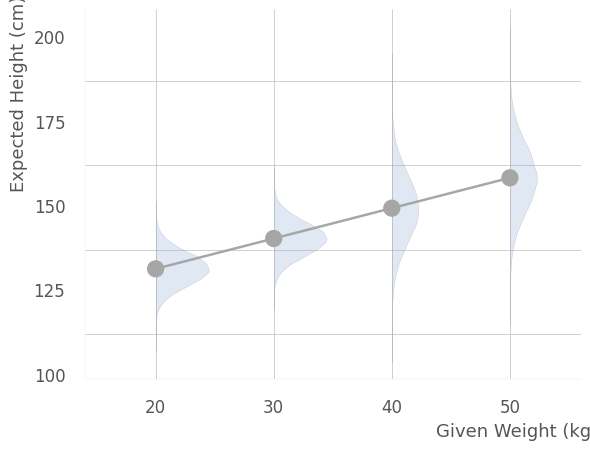

<ggplot: (8461936772376)>

In [136]:
from plotnine import geom_violin
from plotnine import ggplot, aes

t = theme(
          # Overrides
          axis_title_y = element_text(angle = 90, va = 'bottom', ha = 'left', size = 13, color = GRAY3, y = 0.5),
          axis_title_x = element_text(  size = 13, color = GRAY3, x=0.8),
          panel_grid_major_y=element_blank(),
          legend_position="none"
)

lsize = 0.1
shift = -0.06
shift_point = 0.07

# For shifting the violin plot
def alt_sign(x):
    "Alternate +1/-1 if x is even/odd"
    #return (-1) ** x
    return

m1 = aes(x=stage('variable', after_scale='x+shift*x'))                 # shift outward
m2 = aes(x=stage('variable', after_scale='x+shift_point*x'))           # shift outward
m3 = aes( stage('variable', after_scale='x+shift_point*x' ),y='vals' )

fig = \
(ggplot(df_long, aes('variable', 'value',group = 'variable'))
  + geom_violin( alpha=0.3, color=GRAY8, fill=BLUE3, style="right", size=lsize)
  #+ geom_point(m2, alpha=0.005, color=GRAY8,size=0.2)
  + geom_line (data_x_y,aes( x='variable', y='y', group = 'group', size=2),color=GRAY8 )
  + geom_point (data_x_y, aes( x='variable', y='y',size=10), color=GRAY8 )
  + labs(y = "Expected Height (cm)     "  , x = "Given Weight (kg)")
  +SWD_theme() + t
)


fig

(0.0, 1.0, 0.0, 1.0)

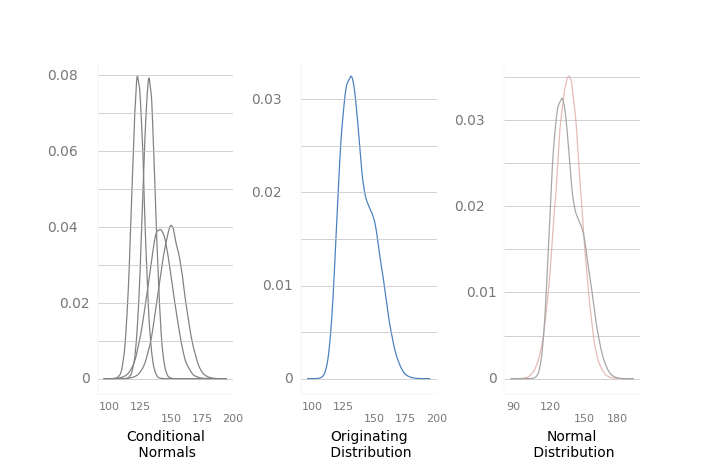

In [137]:
t = theme(
          # Overrides
          axis_title_y = element_text(angle = 90, va = 'bottom', ha = 'left', size = 13, color = GRAY3, y = 0.8),
          axis_title_x = element_text(  size = 13, color = GRAY3, x=0.8),
          #panel_grid_major_y=element_blank(),
          panel_grid_major_x=element_blank(),
          panel_grid_minor_x=element_blank(),
          axis_text_y = element_text( color=GRAY5, size=10)  ,
          axis_text_x = element_text( color=GRAY5, size=8, y = 0, va="top", ha="left")  ,
          #va = 'bottom', ha = 'left', size = 13, color = GRAY3, y = 0.5
          legend_position="none"
)

# Conditional distributions
p1 = \
  (ggplot(df_long, aes(x='value', group='variable') )
  + geom_density (alpha=0.1, color=GRAY6)
  + labs(y = "Density     "  , x = "Given Weight (kg)")
  + scale_x_continuous(limit = [150, 220])
   +SWD_theme() + t
)

# Originating distribution
p2 = \
  (ggplot(df_long, aes(x='value'))
  + geom_density (alpha=0.1,  color=BLUE2)
  + labs(y = "Density     "  , x = "Given Weight (kg)")
  +SWD_theme() + t
)

# Normal Distribution
p3 = \
  (ggplot(df_Normal, aes(x='value'))
  + geom_density (alpha=0.1,  color=RED2)
  + geom_density (df_long, aes(x='value'), color=GRAY8 )
  + labs(y = "Density     "  , x = "Given Weight (kg)")
  +SWD_theme() + t
)

# Empty plotnine figure to place the subplots on. Needs junk data (for backend "copy" reasons).
fig = (ggplot()+geom_blank(data=df) +theme_void()).draw(show=False, return_ggplot=False)

# Create gridspec for adding subpanels to the blank figure
gs = gridspec.GridSpec(1, 3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

gs.update(wspace=0.5, hspace=0.05) # set the spacing between axes.

# Add subplots to the figure
_=p1._draw_using_figure(fig, [ax1])
_=p2._draw_using_figure(fig, [ax2] )
_=p3._draw_using_figure(fig, [ax3] )

fig.dpi = 100
width_in = 7
fig.set_size_inches(width_in , width_in/1.62)

# X axis labels.
fig.axes[1].set_xlabel ('Conditional\n Normals')
fig.axes[2].set_xlabel ('Originating\n Distribution')
fig.axes[3].set_xlabel ('Normal\n Distribution')

ax0 = fig.add_axes( (0,0,1,1))
ax0.axis('Off') # don't draw anything.

In summary the originating distribution is skewed a little to the right.

Now, recalculate the regression model using data sampled from the  originating distribution and see what kind of residual standard error comes back

In [138]:
import scipy
slope, intercept, r, p, se = scipy.stats.linregress(df_long.variable  , df_long.value)

# Residual standard error
preds = intercept + ( slope * df_long['x'] )
rse = np.std (  df_long.value - preds )

# There's no need to plot this because of course the regression will
# estimate the correct parameters
(slope, intercept, rse)

(0.8983876435204431, 113.84219042282712, 7.901714462808587)

In [139]:
# Add the new predictions to our existing data frame
# Predictions are the same as before.
data_x_y ['y_new'] = np_x * slope+ intercept
data_x_y

,x,y,variable,group,y_new
0,20,131.79,20,1,131.809943
1,30,140.79,30,1,140.793820
2,40,149.79,40,1,149.777696
3,50,158.79,50,1,158.761573


Also resample from the conditional distributions as understood by the new model

In [140]:
df_new_model = pd.DataFrame()

for xi in lst_x:
    yi =  xi * slope+ intercept
    df_new_model[xi] = stats.norm.rvs(yi , rse, N)

# A long version of this dataframe is needed for plotting as violin plots
import pandas.api.types as pdtypes # for (sorted) categories.
df_long_new_model = pd.melt(df_new_model,value_vars=[20,30,40,50]  )
df_long_new_model['x'] = df_long['variable']
df_long_new_model['variable'] = df_long['variable'].astype(pdtypes.CategoricalDtype(categories=[10,20,30,40,50,60]))
df_long_new_model.head()

,variable,value,x
0,20,132.941874,20
1,20,128.790230,20
2,20,117.398343,20
3,20,122.085451,20
4,20,127.247041,20


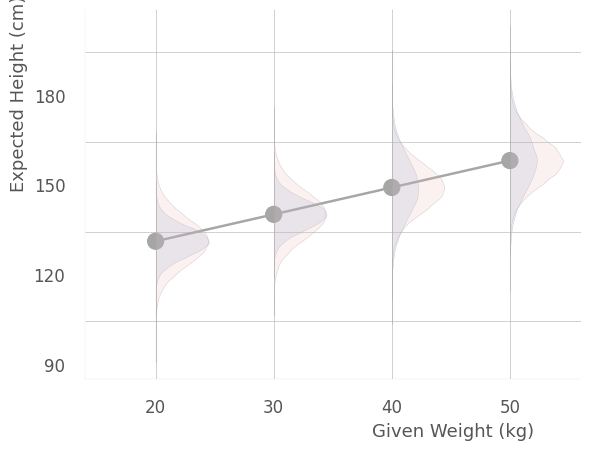

<ggplot: (8461937765479)>

In [141]:
from plotnine import geom_violin
from plotnine import ggplot, aes

t = theme(
          # Overrides
          axis_title_y = element_text(angle = 90, va = 'bottom', ha = 'left', size = 13, color = GRAY3, y = 0.5),
          axis_title_x = element_text(  size = 13, color = GRAY3, x=0.65),
          panel_grid_major_y=element_blank(),
          legend_position="none"
)

lsize = 0.1
shift = -0.06
shift_point = 0.07

# For shifting the violin plot
def alt_sign(x):
    "Alternate +1/-1 if x is even/odd"
    #return (-1) ** x
    return

m1 = aes(x=stage('variable', after_scale='x+shift*x'))                 # shift outward
m2 = aes(x=stage('variable', after_scale='x+shift_point*x'))           # shift outward
m3 = aes( stage('variable', after_scale='x+shift_point*x' ),y='vals' )

fig = \
(ggplot(\
  # All this is the same as before...
    df_long, aes('variable', 'value',group = 'variable'))
  + geom_line (data_x_y,aes( x='variable', y='y', group = 'group', size=2),color=GRAY8 )
  + geom_point (data_x_y, aes( x='variable', y='y',size=10), color=GRAY8 )
  + geom_violin( alpha=0.2, color=GRAY8, fill=BLUE3, style="right", size=lsize)

  # Add the distribution from the new model.
  + geom_violin(df_long_new_model, aes( y='value'),
                alpha=0.2, color=GRAY8, fill=RED2, style="right", size=lsize)

 + labs(y = "Expected Height (cm)     "  , x = "Given Weight (kg)")
  +SWD_theme() + t
)


fig

## So in summary
#### The originating distribution for height is definately a little skewed to the right.  
#### If we run a regresson model against just the originating dataset, then we get the same regressoin line, however, it can clearly be seen that conditional normal distribution is now constant.
